In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import seaborn as sns
from datetime import datetime, time
pd.set_option("display.max_columns",50)
pd.options.mode.chained_assignment = None  # default='warn'

import sys
from Apple_Data import light_preprocess
from UpStraight_Data import preprocess, build_features
from UpStraight_Visualize import plot_day

## Loading UpStraight data

In [3]:
appData_path = "../../apple_health_export_260123/StraightUp_export_260123.csv"
appData = pd.read_csv(appData_path)

In [4]:
appData = preprocess(appData)
appData

,date,appleWatch,state,posture,day,time,state_string,posture_string
0,2023-01-22 09:34:24+00:00,1,1,1,22,09:34:24,Sitting,Slouched
1,2023-01-22 09:45:38+00:00,1,1,1,22,09:45:38,Sitting,Slouched
2,2023-01-22 09:48:00+00:00,1,1,0,22,09:48:00,Sitting,Straight
3,2023-01-22 10:01:29+00:00,1,1,1,22,10:01:29,Sitting,Slouched
4,2023-01-22 10:09:58+00:00,1,1,1,22,10:09:58,Sitting,Slouched
...,...,...,...,...,...,...,...,...
74,2023-01-25 16:40:12+00:00,1,1,1,25,16:40:12,Sitting,Slouched
75,2023-01-25 18:04:43+00:00,1,2,-1,25,18:04:43,Standing,Unavailable
76,2023-01-25 19:13:35+00:00,1,1,1,25,19:13:35,Sitting,Slouched
77,2023-01-25 20:01:57+00:00,1,1,1,25,20:01:57,Sitting,Slouched


In [30]:
appData.dtypes

date              datetime64[ns, UTC]
appleWatch                      int64
state                           int64
posture                         int64
day                             int64
time                           object
state_string                   object
posture_string                 object
dtype: object

In [11]:
appData.state_string.value_counts(normalize=True)

Sitting        0.544304
Standing       0.253165
Active         0.101266
Unavailable    0.050633
Lying          0.050633
Name: state_string, dtype: float64

In [13]:
appData.query("state_string=='Sitting'").posture_string.value_counts(normalize=True)

Slouched    0.906977
Straight    0.093023
Name: posture_string, dtype: float64

## Loading Apple Health Data

In [14]:
path = "../../apple_health_export_260123/apple_health_export_2023-01-26.csv"
data = pd.read_csv(path,nrows=30000) # get the last 20000 entries

/var/folders/yx/_8fch6cj6w5cfvy2xlfjrsyw0000gn/T/ipykernel_74113/2011952730.py:2: DtypeWarning: Columns (21,35,48) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path,nrows=30000) # get the last 20000 entries


In [15]:
# defining relevant columns
sitting_cols = ["AppleStandTime","AppleStandHour"]
relevant_health_cols = ["ActiveEnergyBurned","BasalEnergyBurned","HeartRate","DistanceWalkingRunning","StepCount"]

In [16]:
health = light_preprocess(data[data["type"].isin(sitting_cols+relevant_health_cols)])

/Users/lasse/Library/Mobile Documents/com~apple~CloudDocs/Health Data/watch_data/apple_watch_data_package/notebooks/../Apple_Data.py:20: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data["week"] = data["start"].dt.week


In [17]:
health.type.value_counts()

ActiveEnergyBurned        8070
BasalEnergyBurned         5232
DistanceWalkingRunning    4133
HeartRate                 3999
StepCount                 1414
AppleStandTime             282
AppleStandHour              87
Name: type, dtype: int64

In [18]:
health.date.min()

datetime.date(2023, 1, 20)

In [19]:
appData.dtypes

date              datetime64[ns, UTC]
appleWatch                      int64
state                           int64
posture                         int64
day                             int64
time                           object
state_string                   object
posture_string                 object
dtype: object

## Basic plots

#### HeartRate (1 min)

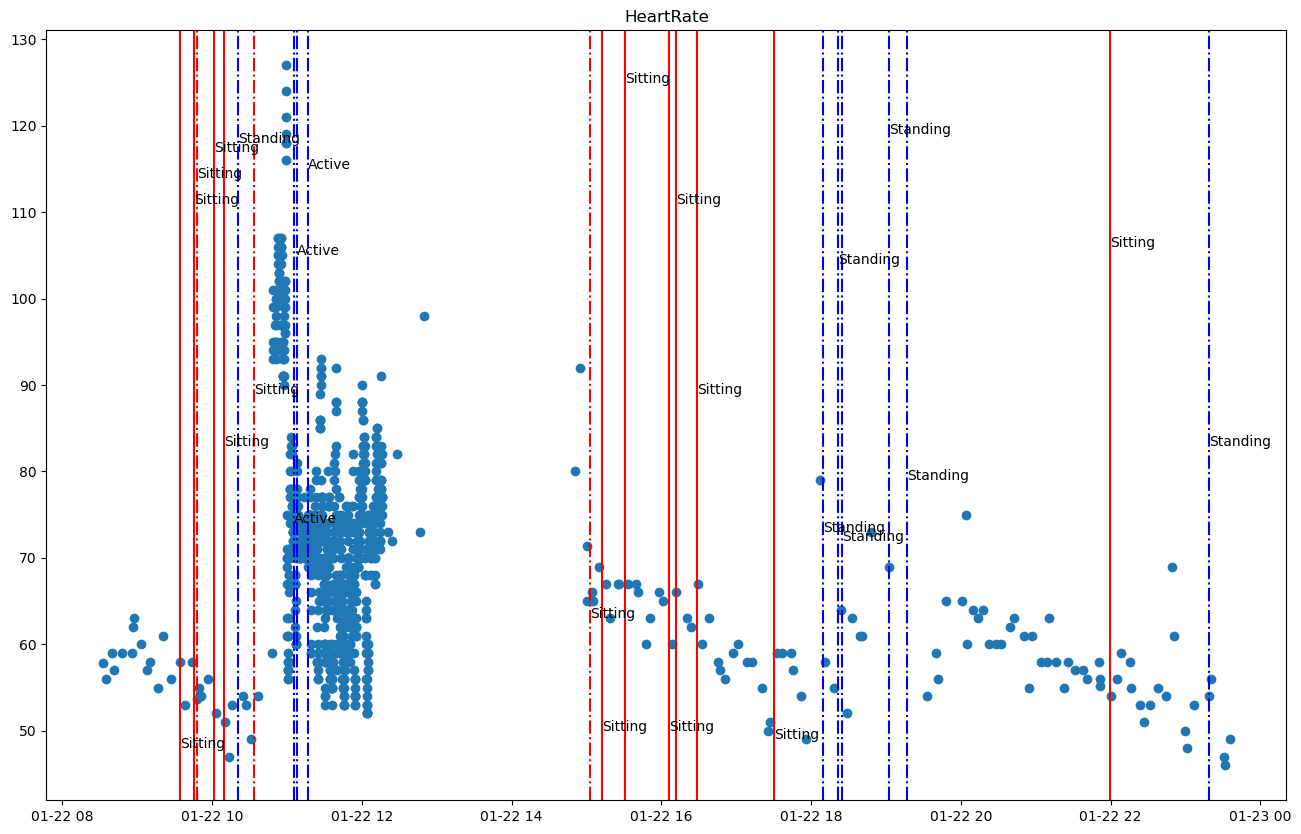

In [69]:
# be able to plot the notifications of a day
plot_day(appData,health,"HeartRate",day=22)

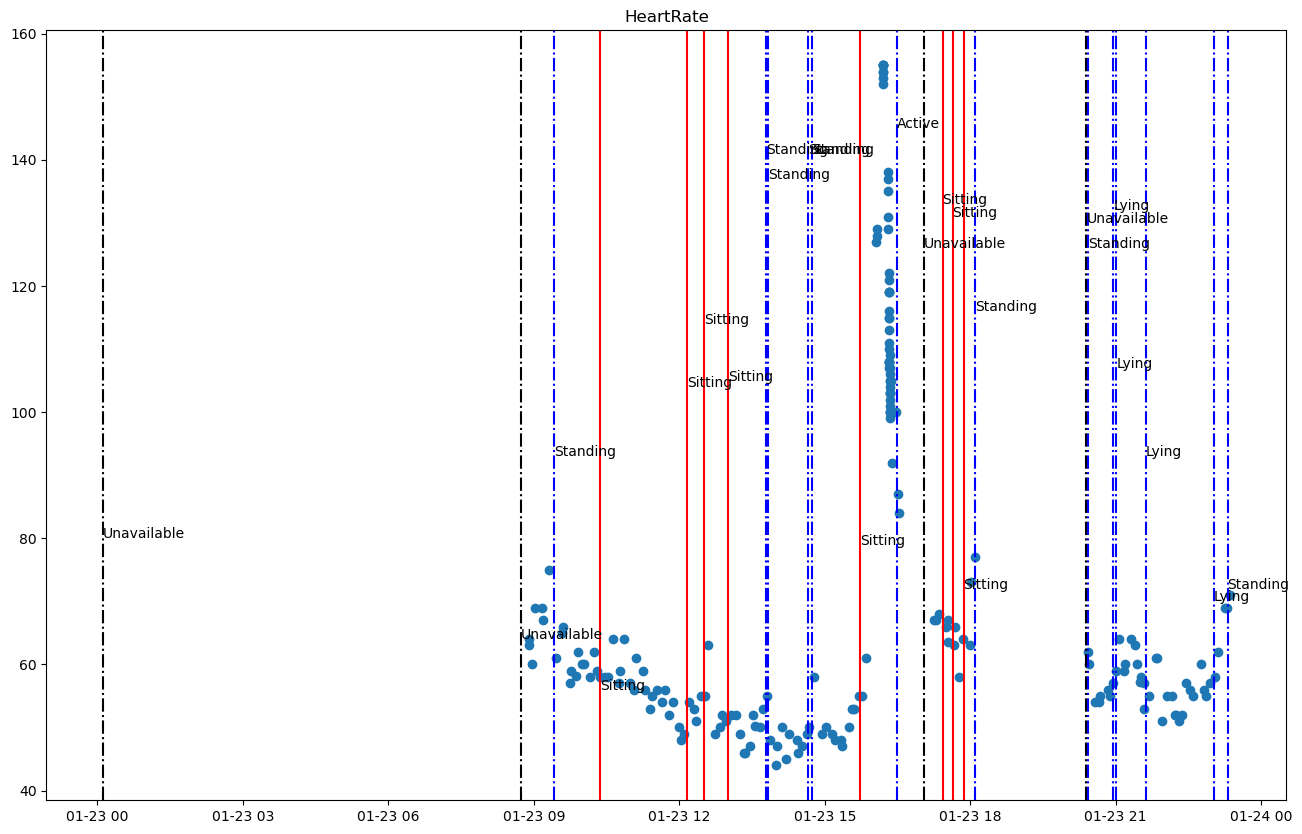

In [71]:
plot_day(appData,health,"HeartRate",day=23)

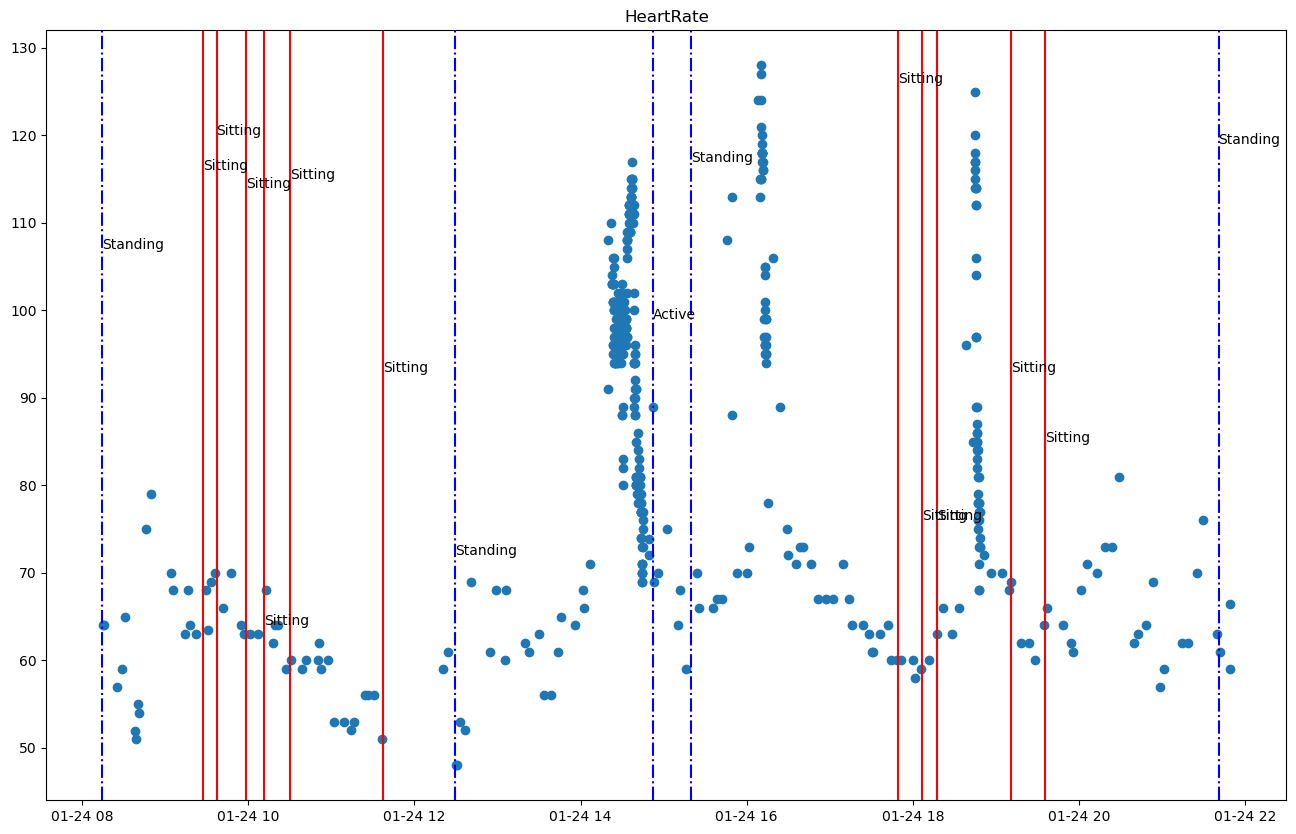

In [72]:
plot_day(appData,health,"HeartRate",day=24)

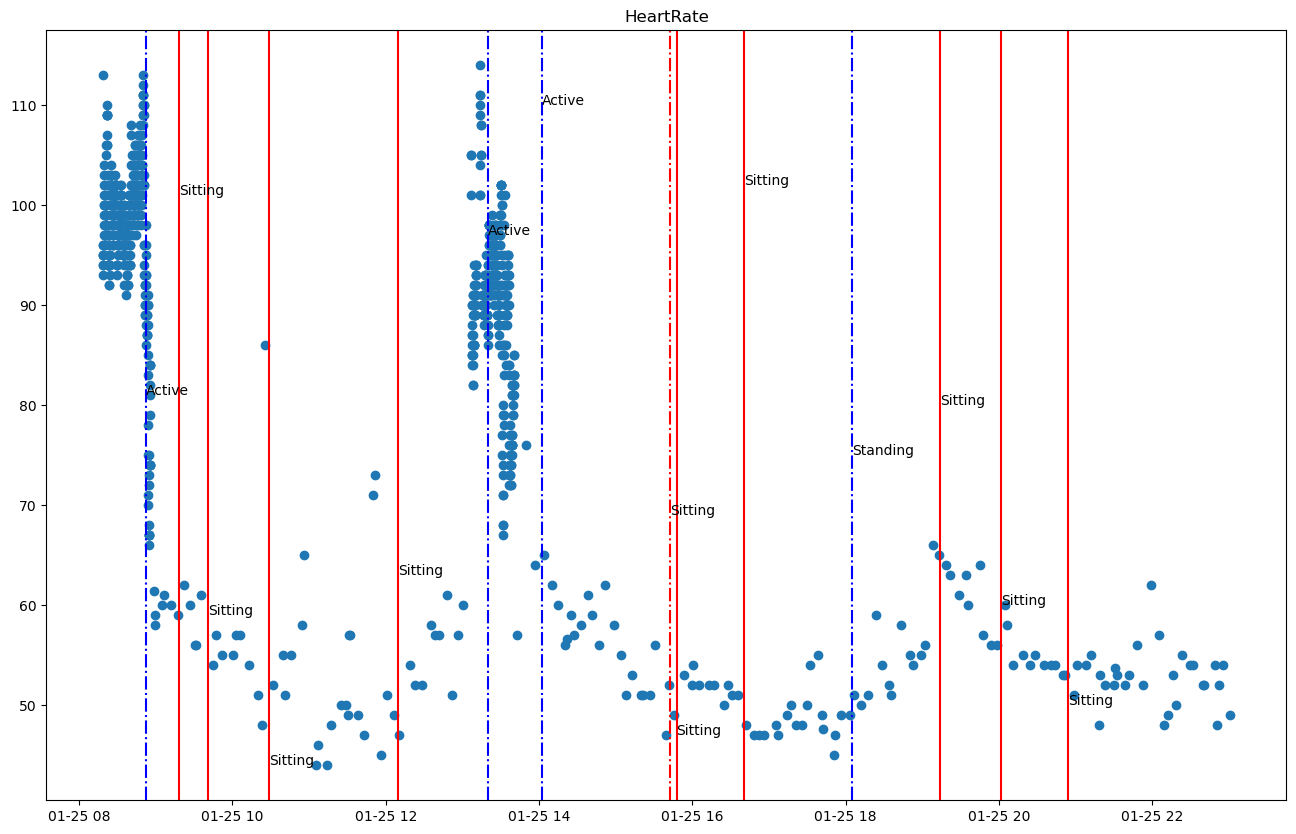

In [73]:
plot_day(appData,health,"HeartRate",day=25)

#### AppleStandTime (5 min)

I think that a data entry is made only if there is at least one standing minute in that 5 minute window. This would explain why there are gaps and why the min value is 1, not 0.

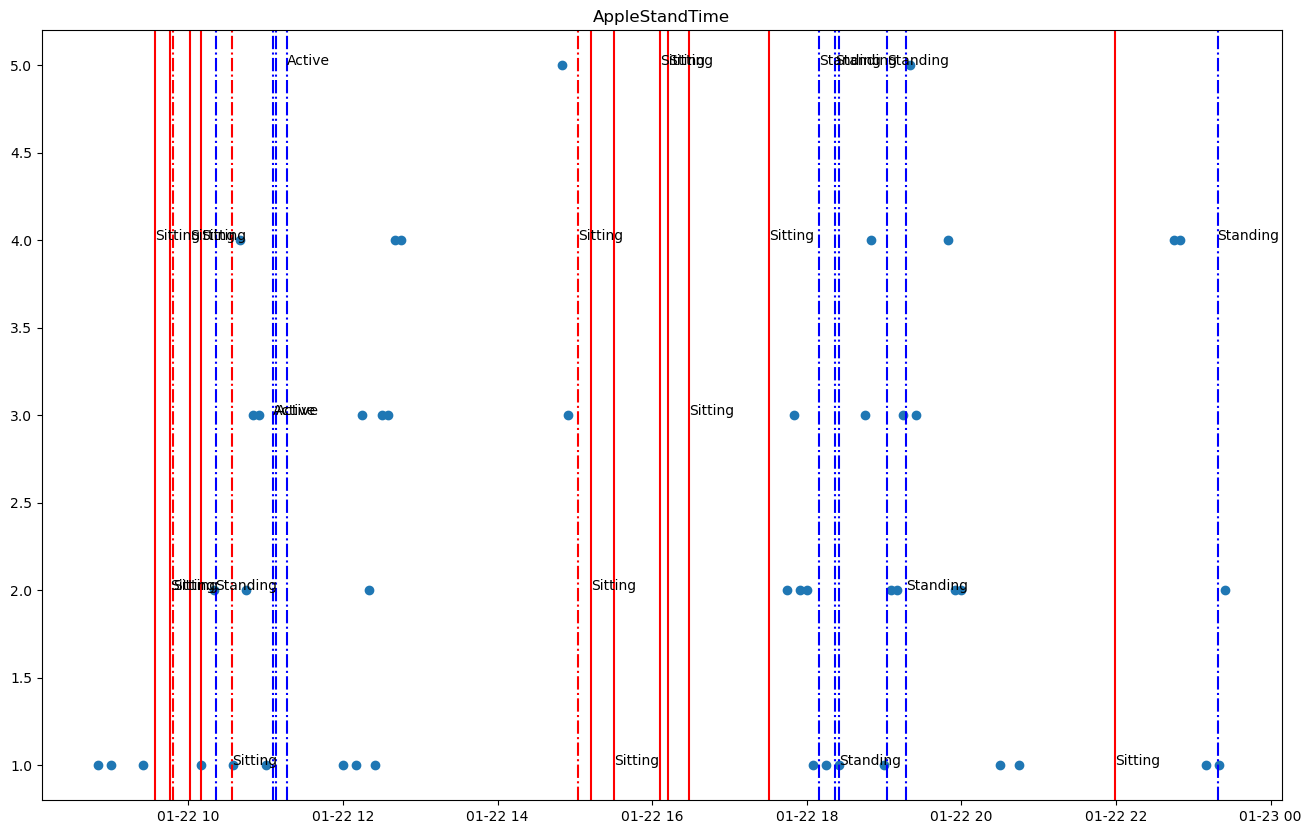

In [75]:
plot_day(appData,health,"AppleStandTime",day=22)

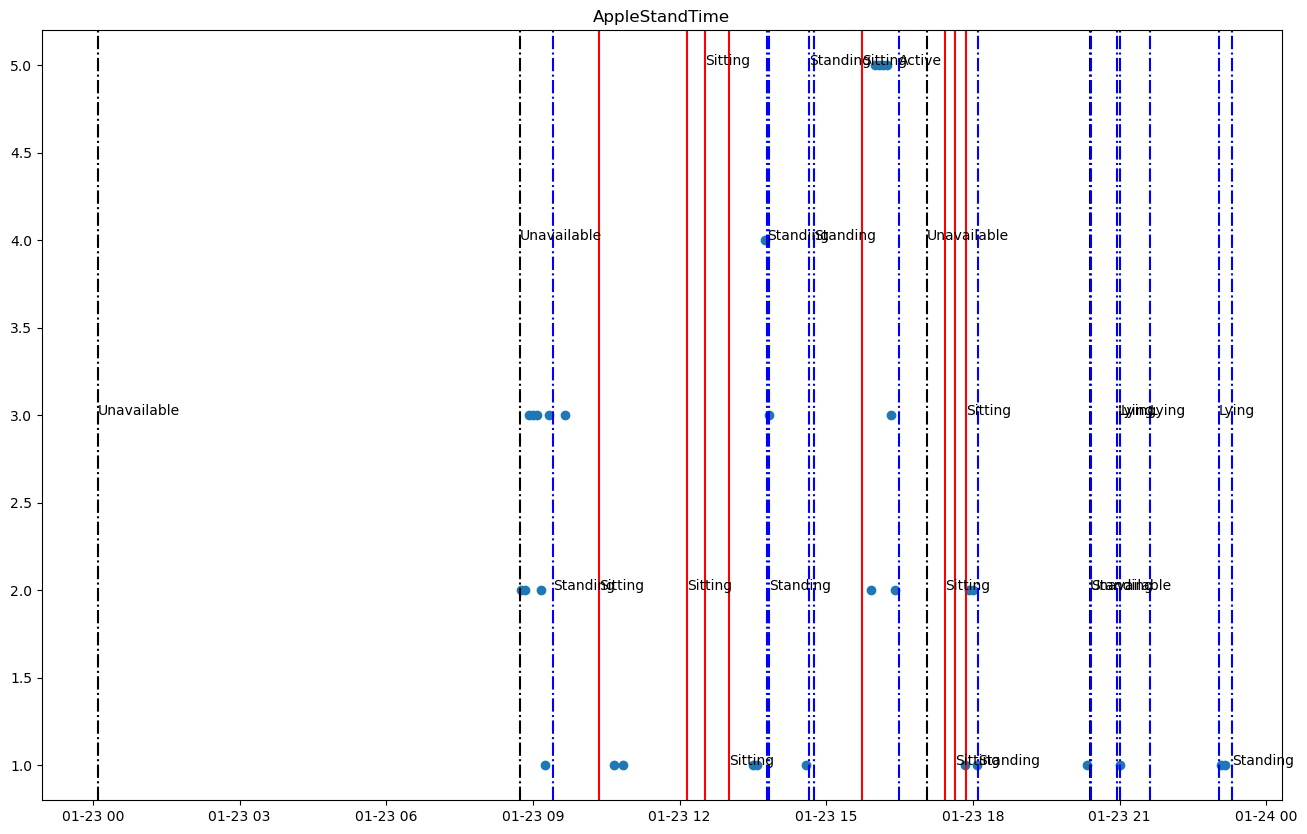

In [76]:
plot_day(appData,health,"AppleStandTime",day=23)

#### ActiveEnergyBurned

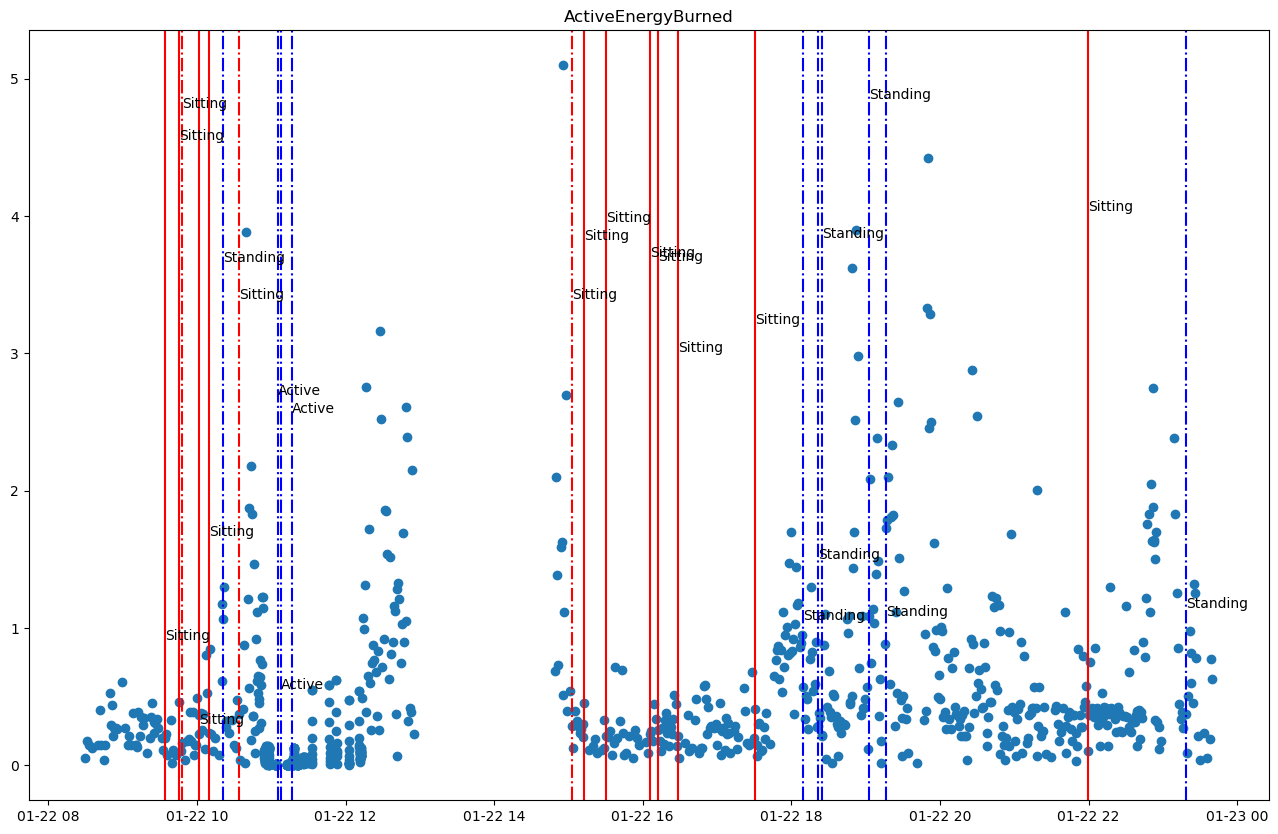

In [80]:
plot_day(appData,health,"ActiveEnergyBurned",day=22)

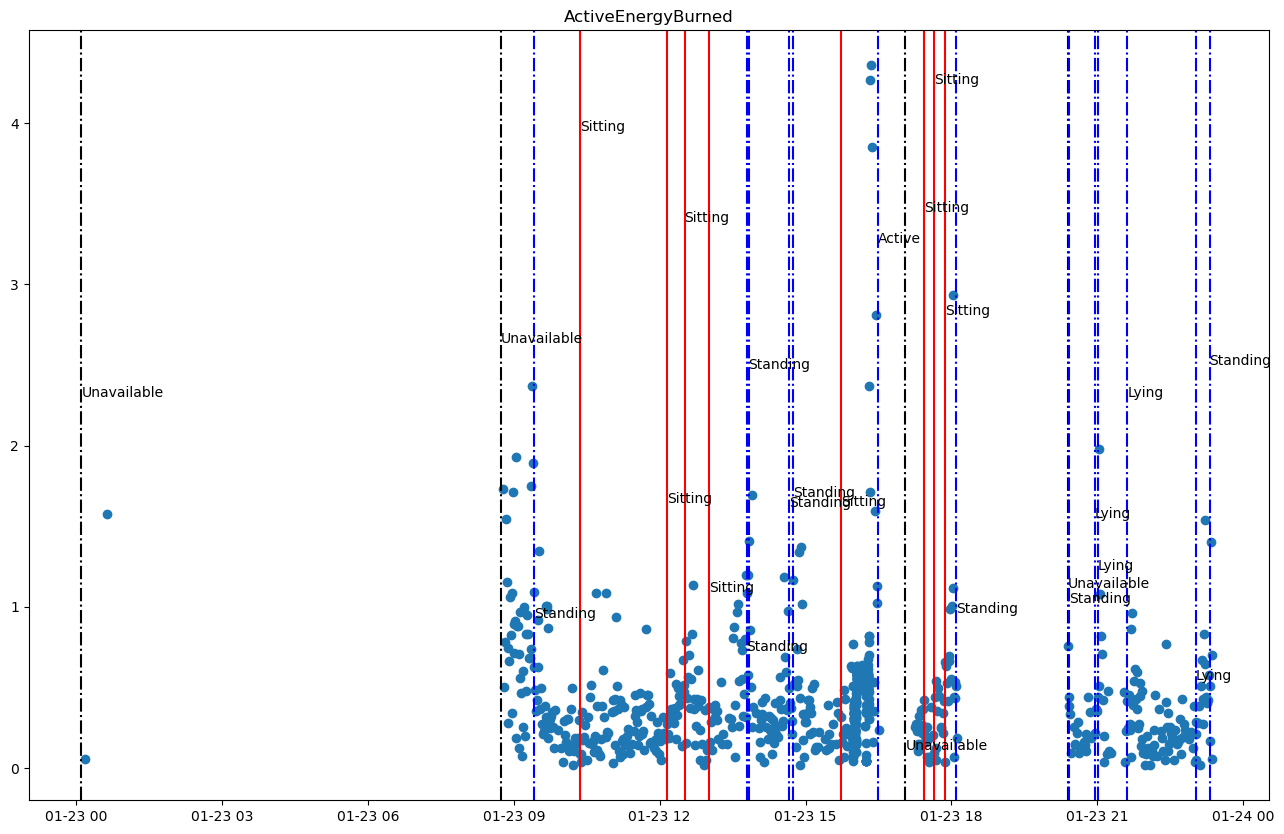

In [81]:
plot_day(appData,health,"ActiveEnergyBurned",day=23)

#### BasalEnergyBurned (useless)

#### DistanceWalkingRunning

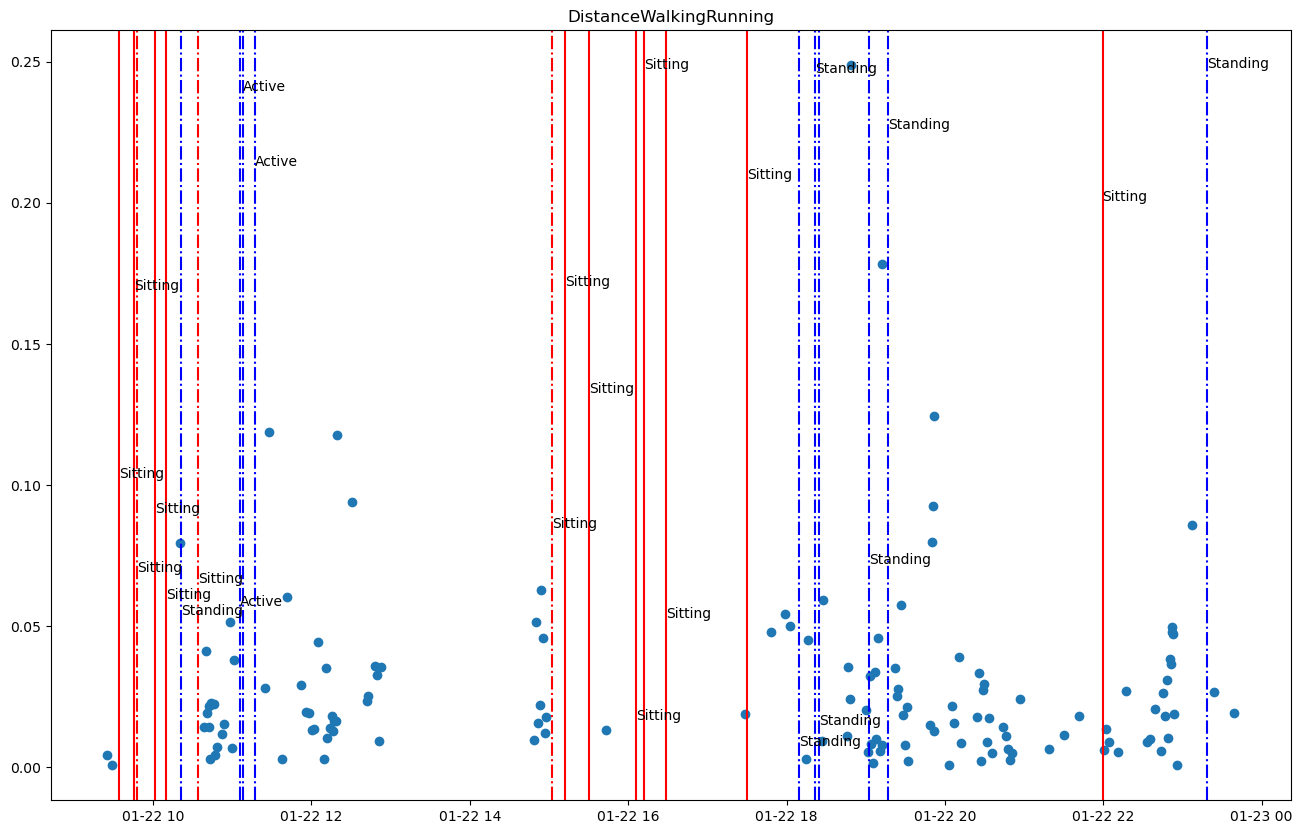

In [111]:
plot_day(appData,health,"DistanceWalkingRunning",day=22)

## Training a simple Classifier

In [41]:
features = build_features(appData,health)

100%|██████████| 75/75 [00:00<00:00, 306.87it/s]


In [43]:
features.shape

(75, 38)

In [73]:
# allow at most 5 missing observation in each feature
max_obs = features.dropna(axis=1,thresh=70).dropna()
max_obs.shape


(69, 28)

In [78]:
X = max_obs.iloc[:,8:]
y = max_obs.state_string

In [85]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X,y)

In [86]:
clf.score(X,y)

0.9130434782608695

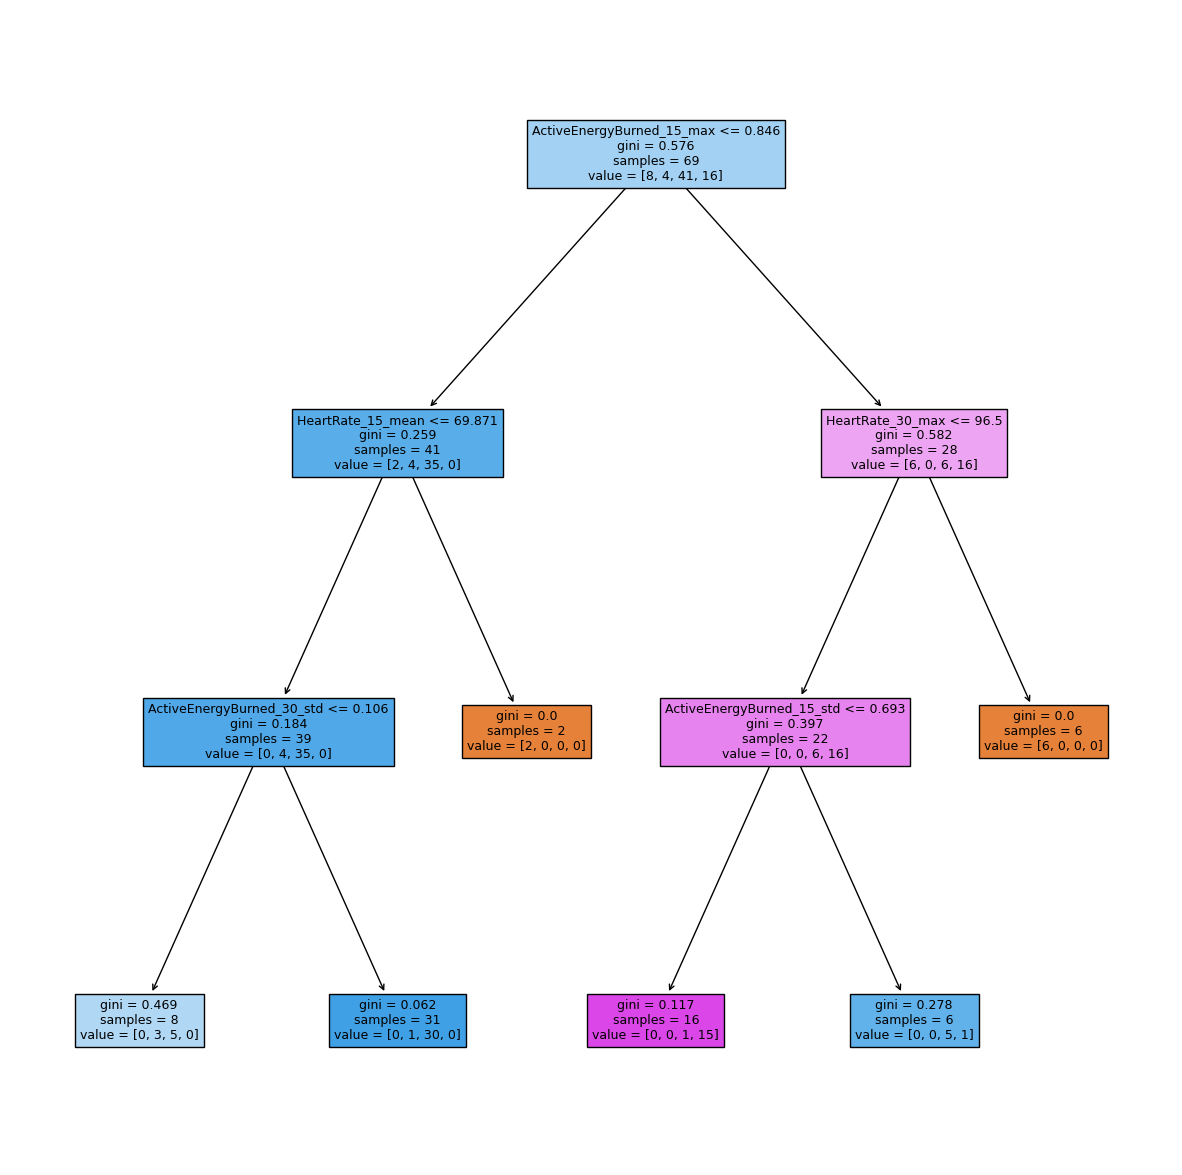

In [92]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,15))
tree.plot_tree(clf,filled=True,feature_names=X.columns)
plt.show()

ActiveEnergy is good for distinguishing standing from sitting. HeartRate is good to categorize active.

In [95]:
y_predicted = clf.predict(X)

[]

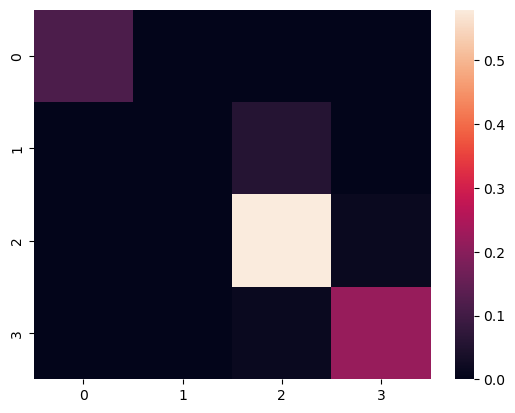

In [99]:
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(y,y_predicted,normalize="all"))
plt.plot()

Some true 1's ("Lying") are in Sitting.

## Simulating Data Generation process

In [97]:
import numpy as np


def calculate_slouching(df,minutes):
    df["sitting_rolling_window"] = (df.sitting.rolling(window=minutes).sum())/minutes
    slouching = [0 if df.sitting[x]==0 else (1/(1+np.exp(-(df.sitting_rolling_window[x]*10)+5))) for x in df.index]
    return slouching

df = pd.DataFrame({
    "minutes": np.linspace(1,120,120),
    "sitting": np.concatenate((np.zeros(20),np.ones(60),np.zeros(5),np.ones(35))),
})

slouching = calculate_slouching(df,20) # 0 if sitting==0, proportional to how much time they spent sitting in the last n minutes if sitting==1
df["slouching"] = slouching



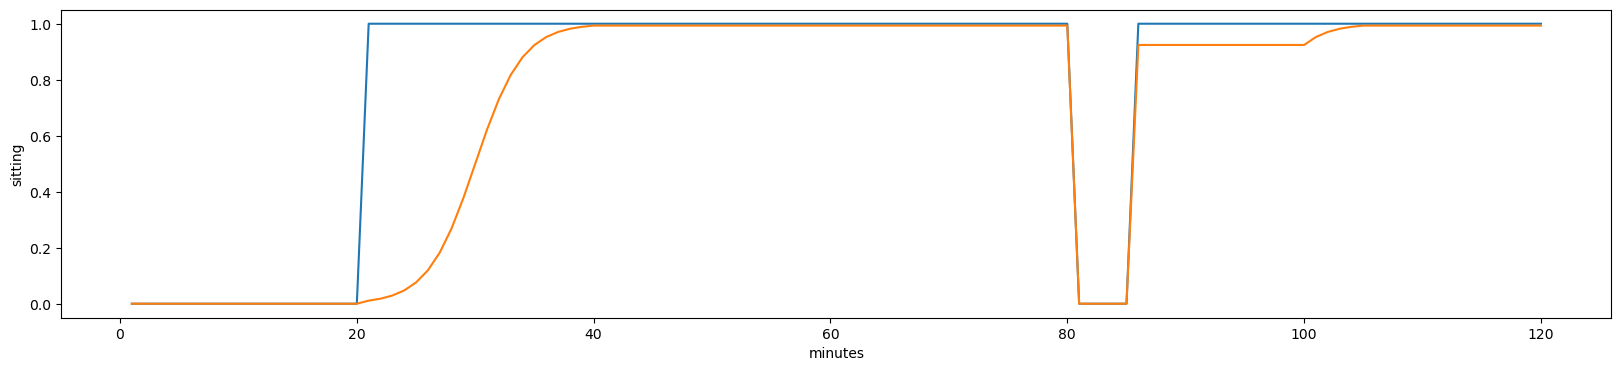

In [98]:
f = plt.figure(figsize=(20,4))
sns.lineplot(df,x="minutes",y="sitting")
sns.lineplot(df,x="minutes",y="slouching")
plt.show()

In [99]:
df.tail(50)

,minutes,sitting,sitting_rolling_window,slouching
70,71.0,1.0,1.00,0.993307
71,72.0,1.0,1.00,0.993307
72,73.0,1.0,1.00,0.993307
73,74.0,1.0,1.00,0.993307
74,75.0,1.0,1.00,0.993307
75,76.0,1.0,1.00,0.993307
76,77.0,1.0,1.00,0.993307
77,78.0,1.0,1.00,0.993307
78,79.0,1.0,1.00,0.993307
79,80.0,1.0,1.00,0.993307
